In [1]:
import numpy as np
import bayes3d as b
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML
import PIL
from PIL import Image
import os
import jax
import jax.numpy as jnp
import plotly.graph_objs as go
from scipy.spatial.transform import Rotation as R
import imageio
import io
from ll_viz import  *

In [2]:
# set up renderer
intrinsics = b.Intrinsics(
 height=100,
 width=100,
 fx=250, fy=250,
 cx=100/2.0, cy=100/2.0,
 near=0.1, far=20
)

b.setup_renderer(intrinsics)

b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(), "sample_objs/cube.obj")
                                , scaling_factor=0.1, mesh_name = "cube_1")
b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(), "sample_objs/cube.obj")
                                , scaling_factor=0.1, mesh_name = "cube_2")
b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(), "sample_objs/occulder.obj")
                                , scaling_factor=0.1, mesh_name = "occ")

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (128, 128, 1024)


In [ ]:
##############################################################################################################
"""
Likelihood test case 1
Description: Observed image has one object, rendered image has no object in camera view

Expected behavior: The likelihood when the hypothesis image is the observed image should be higher than when the 
hypothesis image is the rendered image. The likelihood per pixel should also visually show this
"""
##############################################################################################################

def ll_testcase_1(ll_f, ll_f_per_pixel, ll_f_args, name, ll_f_per_pixel_args = None, scale = 2):
    if ll_f_per_pixel_args == None:
        ll_f_per_pixel_args = ll_f_args

    ll_test_num = 1
    # make poses intersect/collide/penetrate
    obs_pose = jnp.eye(4).at[:3,3].set([-0.15,0,1.5])
    obs_pose = obs_pose @ b.transform_from_axis_angle(jnp.array([1,1,1]), jnp.pi/4)
    # pose_2 = jnp.eye(4).at[:3,3].set([-0.05,0,1.5])
    # pose_2 = pose_2 @ b.transform_from_axis_angle(jnp.array([1,1,1]), jnp.pi/4)
    hypothesis_pose = jnp.eye(4).at[:3,3].set([-1,0,1.5])

    observed_image_PCL = b.RENDERER.render(jnp.stack([obs_pose]), jnp.array([0]))[...,:3]
    hypothesis_image_PCL = b.RENDERER.render(jnp.stack([hypothesis_pose]), jnp.array([0]))[...,:3]

    ll_good = ll_f(observed_image_PCL, observed_image_PCL, *ll_f_args)
    ll_bad = ll_f(observed_image_PCL, hypothesis_image_PCL, *ll_f_args)

    assert ll_good > ll_bad
    print(f"The likelihood with the object in the correct pose is {ll_good}, while the likelihood for the object not in scene is {ll_bad}")

    ll_per_pixel = ll_f_per_pixel(observed_image_PCL, hypothesis_image_PCL, *ll_f_per_pixel_args)
    ll_viz = get_bayes3d_grid_PIL_frame(np.array(ll_per_pixel), scale)

    return b.multi_panel([b.scale_image(b.get_depth_image(observed_image_PCL[...,2]),scale*2),
                    b.scale_image(b.get_depth_image(hypothesis_image_PCL[...,2]),scale*2),
                    b.scale_image(ll_viz,2)],
                    labels = ['Observed', 'Hypothesis', 'Likelihood'],
                    title = 'Likelihood test {} ({} likelihood)'.format(ll_test_num, name))

In [ ]:
# Test with old ll
ll_f = b.threedp3_likelihood_old
ll_f_per_pixel = b.threedp3_likelihood_per_pixel_old
ll_f_args = (0.001,0.001,1000,None,3)
ll_f_per_pixel_args = (0.001,0.001,1000,3)
ll_testcase_1(ll_f, ll_f_per_pixel, ll_f_args, name = 'old',ll_f_per_pixel_args =ll_f_per_pixel_args, scale = 2)

In [ ]:
# Test with new ll
variance = 0.1
ll_f = b.threedp3_likelihood
ll_f_per_pixel = b.threedp3_likelihood_per_pixel
ll_f_args = (variance, None)
ll_testcase_1(ll_f, ll_f_per_pixel, ll_f_args, name = 'new', scale = 2)

In [ ]:
##############################################################################################################
"""
Likelihood test case 2
Description: Observed image has one object. The rendered image has the object off by roughly one pixel

Expected behavior: The likelihood when the hypothesis image is the observed image should be close to 
the case where the hypothesis image is the rendered image. The likelihood per pixel should also visually show this.
"""
##############################################################################################################

def ll_testcase_2(ll_f, ll_f_per_pixel, ll_f_args, name, ll_f_per_pixel_args = None, scale = 2):
    if ll_f_per_pixel_args == None:
        ll_f_per_pixel_args = ll_f_args

    ll_test_num = 2
    # make poses intersect/collide/penetrate
    obs_pose = jnp.eye(4).at[:3,3].set([0,0,1.5])
    obs_pose = obs_pose @ b.transform_from_axis_angle(jnp.array([1,1,1]), jnp.pi/4)
    # pose_2 = jnp.eye(4).at[:3,3].set([-0.05,0,1.5])
    # pose_2 = pose_2 @ b.transform_from_axis_angle(jnp.array([1,1,1]), jnp.pi/4)
    hypothesis_pose = jnp.eye(4).at[:3,3].set([0.01,0,1.5])
    hypothesis_pose = hypothesis_pose @ b.transform_from_axis_angle(jnp.array([1,1,1]), jnp.pi/4)

    observed_image_PCL = b.RENDERER.render(jnp.stack([obs_pose]), jnp.array([0]))[...,:3]
    hypothesis_image_PCL = b.RENDERER.render(jnp.stack([hypothesis_pose]), jnp.array([0]))[...,:3]

    ll_good = ll_f(observed_image_PCL, observed_image_PCL, *ll_f_args)
    ll_bad = ll_f(observed_image_PCL, hypothesis_image_PCL, *ll_f_args)

    assert ll_good > ll_bad
    print(f"The likelihood with the object in the exact pose is {ll_good}, while the likelihood for the object slightly off is {ll_bad}")

    ll_per_pixel = ll_f_per_pixel(observed_image_PCL, hypothesis_image_PCL, *ll_f_per_pixel_args)
    ll_viz = get_bayes3d_grid_PIL_frame(np.array(ll_per_pixel), scale)

    return b.multi_panel([b.scale_image(b.get_depth_image(observed_image_PCL[...,2]),scale*2),
                    b.scale_image(b.get_depth_image(hypothesis_image_PCL[...,2]),scale*2),
                    b.scale_image(ll_viz,2)],
                    labels = ['Observed', 'Hypothesis', 'Likelihood'],
                    title = 'Likelihood test {} ({} likelihood)'.format(ll_test_num, name))

In [ ]:
# Test with old ll
ll_f = b.threedp3_likelihood_old
ll_f_per_pixel = b.threedp3_likelihood_per_pixel_old
ll_f_args = (0.001,0.001,1000,None,3)
ll_f_per_pixel_args = (0.001,0.001,1000,3)
ll_testcase_2(ll_f, ll_f_per_pixel, ll_f_args, name = 'old',ll_f_per_pixel_args =ll_f_per_pixel_args, scale = 2)

In [ ]:
# Test with new ll
variance = 0.1
ll_f = b.threedp3_likelihood
ll_f_per_pixel = b.threedp3_likelihood_per_pixel
ll_f_args = (variance, None)
ll_testcase_2(ll_f, ll_f_per_pixel, ll_f_args, name = 'new', scale = 2)

In [ ]:
##############################################################################################################
"""
Likelihood test case 3
Description: There are 2 cases of observed images, one is where the object is near the camera, the other is
where it is far from the camera

Expected behavior: We will let the hypothesized image for each observed image be the same image itself. What
we hope to see is that the likelihoods should be the same in either case (should not depend on depth from camera)
"""
##############################################################################################################

def ll_testcase_3(ll_f, ll_f_per_pixel, ll_f_args, name, ll_f_per_pixel_args = None, scale = 2):
    if ll_f_per_pixel_args == None:
        ll_f_per_pixel_args = ll_f_args

    ll_test_num = 3

    obs_pose1 = jnp.eye(4).at[:3,3].set([0,0,1])
    obs_pose1 = obs_pose1 @ b.transform_from_axis_angle(jnp.array([1,1,1]), jnp.pi/4)
    obs_pose2 = jnp.eye(4).at[:3,3].set([0,0,5])
    obs_pose2 = obs_pose2 @ b.transform_from_axis_angle(jnp.array([1,1,1]), jnp.pi/4)

    obs1_image_PCL = b.RENDERER.render(jnp.stack([obs_pose1]), jnp.array([0]))[...,:3]
    obs2_image_PCL = b.RENDERER.render(jnp.stack([obs_pose2]), jnp.array([0]))[...,:3]

    ll_near = ll_f(obs1_image_PCL, obs1_image_PCL, *ll_f_args)
    ll_far = ll_f(obs2_image_PCL, obs2_image_PCL, *ll_f_args)

    print(f"The likelihood with the object near is {ll_near}, while the likelihood for the object far is {ll_far}")

    ll_per_pixel_near = ll_f_per_pixel(obs1_image_PCL, obs1_image_PCL, *ll_f_per_pixel_args)
    ll_viz_near = get_bayes3d_grid_PIL_frame(np.array(ll_per_pixel_near), scale)

    ll_per_pixel_far = ll_f_per_pixel(obs2_image_PCL, obs2_image_PCL, *ll_f_per_pixel_args)
    ll_viz_far = get_bayes3d_grid_PIL_frame(np.array(ll_per_pixel_far), scale)

    return b.multi_panel([b.scale_image(ll_viz_near,2),
                    b.scale_image(ll_viz_far,2)],
                    labels = ['Object near', 'Object far'],
                    title = 'Likelihood test {} ({} likelihood)'.format(ll_test_num, name))

In [ ]:
# Test with old ll
ll_f = b.threedp3_likelihood_old
ll_f_per_pixel = b.threedp3_likelihood_per_pixel_old
ll_f_args = (0.001,0.001,1000,None,3)
ll_f_per_pixel_args = (0.001,0.001,1000,3)
ll_testcase_3(ll_f, ll_f_per_pixel, ll_f_args, name = 'old',ll_f_per_pixel_args =ll_f_per_pixel_args, scale = 2)

In [ ]:
# Test with new ll
variance = 0.1
ll_f = b.threedp3_likelihood
ll_f_per_pixel = b.threedp3_likelihood_per_pixel
ll_f_args = (variance, None)
ll_testcase_3(ll_f, ll_f_per_pixel, ll_f_args, name = 'new', scale = 2)

In [7]:
##############################################################################################################
"""
Likelihood test case 4
Description: There are 2 cases of observed images, one is where the object is near the camera, the other is
where it is far from the camera. We have 2 rendered images from each observed image, each is slightly off
on the horizontal axis by the same amount

Expected behavior: We will let the hypothesized image for each observed image be the rendered image. What
we hope to see is that the likelihoods should be the same in both near and far cases
"""
##############################################################################################################

def ll_testcase_4(ll_f, ll_f_per_pixel, ll_f_args, name, ll_f_per_pixel_args = None, scale = 2):
    if ll_f_per_pixel_args == None:
        ll_f_per_pixel_args = ll_f_args

    ll_test_num = 4

    obs_pose1 = jnp.eye(4).at[:3,3].set([0,0,1])
    obs_pose1 = obs_pose1 @ b.transform_from_axis_angle(jnp.array([1,1,1]), jnp.pi/4)
    obs_pose2 = jnp.eye(4).at[:3,3].set([0,0,5])
    obs_pose2 = obs_pose2 @ b.transform_from_axis_angle(jnp.array([1,1,1]), jnp.pi/4)

    hyp_pose1 = jnp.eye(4).at[:3,3].set([0.01,0,1])
    hyp_pose1 = hyp_pose1 @ b.transform_from_axis_angle(jnp.array([1,1,1]), jnp.pi/4)
    hyp_pose2 = jnp.eye(4).at[:3,3].set([0.01,0,5])
    hyp_pose2 = hyp_pose2 @ b.transform_from_axis_angle(jnp.array([1,1,1]), jnp.pi/4)

    obs1_image_PCL = b.RENDERER.render(jnp.stack([obs_pose1]), jnp.array([0]))[...,:3]
    obs2_image_PCL = b.RENDERER.render(jnp.stack([obs_pose2]), jnp.array([0]))[...,:3]
    hyp1_image_PCL = b.RENDERER.render(jnp.stack([hyp_pose1]), jnp.array([0]))[...,:3]
    hyp2_image_PCL = b.RENDERER.render(jnp.stack([hyp_pose2]), jnp.array([0]))[...,:3]

    ll_near = ll_f(obs1_image_PCL, hyp1_image_PCL, *ll_f_args)
    ll_far = ll_f(obs2_image_PCL, hyp2_image_PCL, *ll_f_args)

    print(f"The likelihood with the object near (and slightly off) is {ll_near},\n while the likelihood for the object far (and slightly off by the same amount) is {ll_far}")

    ll_per_pixel_near = ll_f_per_pixel(obs1_image_PCL, hyp1_image_PCL, *ll_f_per_pixel_args)
    ll_viz_near = get_bayes3d_grid_PIL_frame(np.array(ll_per_pixel_near), scale)

    ll_per_pixel_far = ll_f_per_pixel(obs2_image_PCL, hyp2_image_PCL, *ll_f_per_pixel_args)
    ll_viz_far = get_bayes3d_grid_PIL_frame(np.array(ll_per_pixel_far), scale)

    return b.multi_panel([b.scale_image(ll_viz_near,2),
                    b.scale_image(ll_viz_far,2)],
                    labels = ['Object near', 'Object far'],
                    title = 'Likelihood test {} ({} likelihood)'.format(ll_test_num, name))

The likelihood with the object near (and slightly off) is -16640.171875,
 while the likelihood for the object far (and slightly off by the same amount) is -16081.6484375


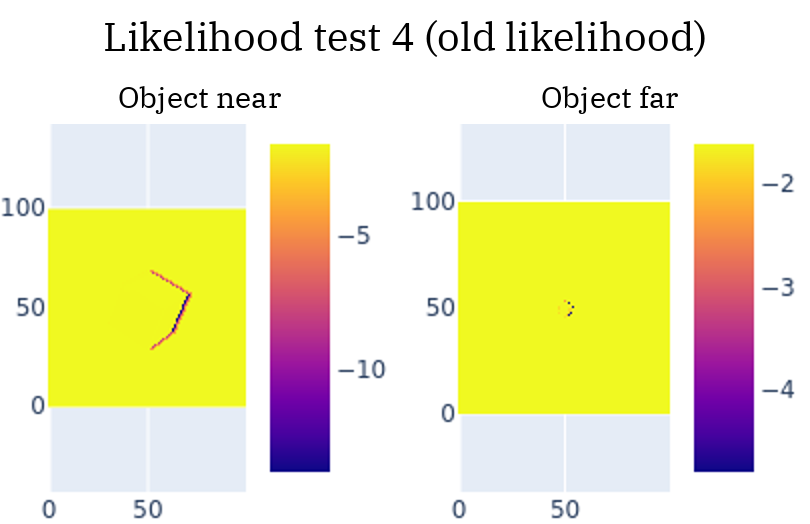

In [8]:
# Test with old ll
ll_f = b.threedp3_likelihood_old
ll_f_per_pixel = b.threedp3_likelihood_per_pixel_old
ll_f_args = (0.001,0.001,1000,None,3)
ll_f_per_pixel_args = (0.001,0.001,1000,3)
ll_testcase_4(ll_f, ll_f_per_pixel, ll_f_args, name = 'old',ll_f_per_pixel_args =ll_f_per_pixel_args, scale = 2)

The likelihood with the object near (and slightly off) is 9.79699993133545,
 while the likelihood for the object far (and slightly off by the same amount) is 9.991000175476074


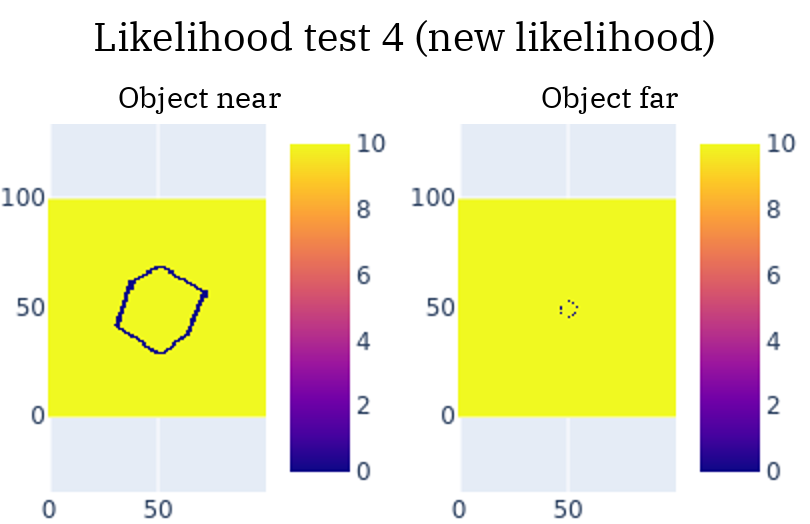

In [9]:
# Test with new ll
variance = 0.1
ll_f = b.threedp3_likelihood
ll_f_per_pixel = b.threedp3_likelihood_per_pixel
ll_f_args = (variance, None)
ll_testcase_4(ll_f, ll_f_per_pixel, ll_f_args, name = 'new', scale = 2)

In [ ]:
##############################################################################################################
"""
Likelihood test case 5
Description: Observed image has one object. The rendered image has the object off by roughly one pixel

Expected behavior: The likelihood for the observed|rendered should be the same as rendered|observed.
"""
##############################################################################################################

def ll_testcase_5(ll_f, ll_f_per_pixel, ll_f_args, name, ll_f_per_pixel_args = None, scale = 2):
    if ll_f_per_pixel_args == None:
        ll_f_per_pixel_args = ll_f_args

    ll_test_num = 5
    # make poses intersect/collide/penetrate
    obs_pose = jnp.eye(4).at[:3,3].set([0,0,1.5])
    obs_pose = obs_pose @ b.transform_from_axis_angle(jnp.array([1,1,1]), jnp.pi/4)
    hypothesis_pose = jnp.eye(4).at[:3,3].set([0.05,0,1.5])
    hypothesis_pose = hypothesis_pose @ b.transform_from_axis_angle(jnp.array([0,0,1]), jnp.pi/4)

    observed_image_PCL = b.RENDERER.render(jnp.stack([obs_pose]), jnp.array([0]))[...,:3]
    hypothesis_image_PCL = b.RENDERER.render(jnp.stack([hypothesis_pose]), jnp.array([0]))[...,:3]

    ll_obs_given_hypothesis = ll_f(observed_image_PCL, hypothesis_image_PCL, *ll_f_args)
    ll_hypothesis_given_obs = ll_f(hypothesis_image_PCL, observed_image_PCL, *ll_f_args)

    print(f"The likelihood with observed|rendered is {ll_obs_given_hypothesis}, while the likelihood for rendered|observed is {ll_hypothesis_given_obs}")

    ll_per_pixel_obs_given_hypothesis = ll_f_per_pixel(observed_image_PCL, hypothesis_image_PCL, *ll_f_per_pixel_args)
    ll_viz_obs_given_hypothesis = get_bayes3d_grid_PIL_frame(np.array(ll_per_pixel_obs_given_hypothesis), scale)
    ll_per_pixel_hypothesis_given_obs = ll_f_per_pixel(hypothesis_image_PCL, observed_image_PCL, *ll_f_per_pixel_args)
    ll_viz_hypothesis_given_obs = get_bayes3d_grid_PIL_frame(np.array(ll_per_pixel_hypothesis_given_obs), scale)

    return b.multi_panel([b.scale_image(b.get_depth_image(observed_image_PCL[...,2]),scale*2),
                    b.scale_image(b.get_depth_image(hypothesis_image_PCL[...,2]),scale*2),
                    b.scale_image(ll_viz_obs_given_hypothesis,scale),
                    b.scale_image(ll_viz_hypothesis_given_obs,scale)],
                    labels = ['Observed', 'Hypothesis', 'Obs|Hypothesis', 'Hypothesis|Obs'],
                    title = 'Likelihood test {} ({} likelihood)'.format(ll_test_num, name))